# Preprocessing

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import seaborn as sns

import time



import torch

from torch.utils.data import DataLoader

import torch.utils.data as data_utils


In [3]:
import torch







# Device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# Path of the model (saved/to save)

modelFolder = './models/'



# When True, retrain the whole model

retrain = True



# Downsample the dataset

ds = True



# Size of the split

trainSize = 0.75

valSize = 0.05

testSize = 0.20



# Specify number of seconds for the window. Default: 16

window_size = 16



# Model hyper-parameters

batch_size = 32

learning_rate = 1e-3



# Seed for reproducibility

seed = 42



# Classes to drop in the dataset

classes_to_drop=[

    'stabf','stab']




In [4]:
import numpy as np

import os

import pandas as pd

import random



from imblearn.under_sampling import RandomUnderSampler

from sklearn import preprocessing

from sklearn.metrics import f1_score

from torch.utils.data import Dataset



import torch

import torch.nn as nn







def setSeed(seed=seed):

    """

    Setting the seed for reproducibility

    """

    random.seed(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)

    torch.cuda.manual_seed(seed)

    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True

    torch.backends.cudnn.benchmark = True



setSeed()



def min_max_norm(self,col):

    self._data[col]=(self._data[col]-self._data[col].min())/(self._data[col].max()-self._data[col].min())





def std_scaler(self,col):

    self._data[col]=(self._data[col]-self._data[col].mean())/(self._data[col].std())





def f1(test_loader, model):

    f1 = 0

    with torch.no_grad():

        for i, (data, labels) in enumerate(test_loader):

            outputs = model(data)

            pred = outputs.data.max(1, keepdim=True)[1]

            f1 += f1_score(labels, pred, average='macro')

    avg_f1 = f1/len(test_loader)

    return (avg_f1)





class CustomDataset(Dataset):

    def __init__(self, file_path='/kaggle/working/new_dataset.csv', classes_to_drop=classes_to_drop, window_size=window_size, normalize=True, normalize_method='mean_std', auth=False, target=None):



        self._window_size=window_size

        self._data=pd.read_csv(file_path)



        # if auth==True:

        #     if target != 'J':

        #         self._data = self._data[self._data['stabf'].isin([target, 'J'])]

        #     else:

        #         self._data = self._data[self._data['stabf'].isin([target, 'I'])]



        #     self._data['stabf'] = self._data['stabf'].apply(lambda x: target if x == target else 'Z')

        #     self._data['stabf'] = self._data['stabf'].map({target: 1, 'Z': 0}).fillna(0).astype(int)





        # # Random Undersampling

        # X = self._data.drop('stabf', axis=1)

        # y = self._data['stabf']



        # # sampler = RandomUnderSampler(sampling_strategy='not minority', random_state=seed)

        # # X_resampled, y_resampled = sampler.fit_resample(X, y)



        # # X_resampled['Class'] = y_resampled

        # self._data = X



        # The data is sorted by Class A,B,C the indexes of the dataframe have restarted by ignore index

        self._data = self._data.sort_values(by=['stabf'], inplace=False,ignore_index = True)



        # class_uniq contains the letters of the drivers A,B and it loops across all of them

        for class_uniq in list(self._data['stabf'].unique()):

            # Find the total number of elements belonging to a class

            tot_number=sum(self._data['stabf']==class_uniq)

            # Number of elements to drop so that the class element is divisible by window size

            to_drop=tot_number%window_size

            # Returns the index of the first element of the class

            index_to_start_removing=self._data[self._data['stabf']==class_uniq].index[0]

            # Drop element from first element to the element required

            self._data.drop(self._data.index[index_to_start_removing:index_to_start_removing+to_drop],inplace=True)





        # Resetting index of dataframe after dropping values

        self._data = self._data.reset_index()

        self._data = self._data.drop(['index'], axis=1)



        index_starting_class=[] # This array contains the starting index of each class in the df

        for class_uniq in list(self._data['stabf'].unique()):

            # Appending the index of first element of each clas

            index_starting_class.append(self._data[self._data['stabf']==class_uniq].index[0])



        # Create the sequence of indexs of the windows

        sequences=[]

        for i in range(len(index_starting_class)):

            # Check if beginning of next class is there

            if i!=len(index_starting_class)-1:

                ranges=np.arange(index_starting_class[i], index_starting_class[i+1])

            else:

                ranges = np.arange(index_starting_class[i], len(self._data))

            for j in range(0,len(ranges),int(self._window_size/2)):

                if len(ranges[j:j+self._window_size])==16:

                    sequences.append(ranges[j:j+self._window_size])

        self._sequences=sequences





        # Take only the 'Class' which are the actual labels and store it in the labels of self

        self._labels=self._data['stabf']

        # Dropping columns which have constant measurements because they would return nan in std

        self._data.drop(classes_to_drop, inplace=True, axis=1)



        # Function to normalize the data either with min_max or mean_std

        if normalize and not auth:

            for col in self._data.columns:

                if normalize_method=='min_max':

                    min_max_norm(self,col)

                elif normalize_method=="mean_std":

                    std_scaler(self,col)



        # Create the array holding the windowed multidimensional arrays

        X=np.empty((len(sequences), self._window_size, len(self._data.columns)))

        y=[]



        for n_row, sequence in enumerate(sequences):

            X[n_row,:,:]=self._data.iloc[sequence]

            # The corresponding driver of the sequence is the driver at first sequence

            y.append(self._labels[sequence[0]])



        assert len(y)==len(X)

        # Assign the windowed dataset to the X of self

        self._X= X



        # Targets is a transformed version of y with drivers are encoded into 0 to 9

        targets = preprocessing.LabelEncoder().fit_transform(y)

        class_labels = encoder.classes_

        for code, label in enumerate(class_labels):

          print(f'Code: {code} -> Label: {label}')

        targets = torch.as_tensor(targets)  # Just converting it to a pytorch tensor

        self._y=targets # Assign it to y of self





    def __len__(self):

        return len(self._X)





    def __getitem__(self, index):

        return torch.FloatTensor(self._X[index,:,:]), self._y[index]





def evaluate(model, dataloader, criterion):

    model.eval()

    running_loss = 0.0

    running_corrects = 0

    y_true = []

    y_pred = []



    for inputs, labels in dataloader:

        inputs = inputs.to(device)

        labels = labels.to(device)



        inputs = inputs

        labels = labels



        # Forward pass

        with torch.no_grad():

            outputs = model(inputs)

            loss = criterion(outputs, labels)



        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels.data)



        # Collect predictions and true labels

        y_true += labels.data.cpu().numpy().tolist()

        y_pred += preds.cpu().numpy().tolist()



    # Calculate accuracy and loss

    epoch_loss = running_loss / len(dataloader.dataset)

    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    epoch_f1 = f1_score(y_true, y_pred, average='macro')



    return epoch_loss, epoch_acc, epoch_f1





def evaluateBinary(model, dataloader, criterion):

    model.eval()

    running_loss = 0.0

    running_corrects = 0

    y_true = []

    y_pred = []



    for inputs, labels in dataloader:

        inputs = inputs.to(device)

        labels = labels.to(device)



        # Forward pass

        with torch.no_grad():

            outputs = model(inputs)

            # loss = criterion(outputs, labels)

            loss = criterion(outputs.squeeze(), labels.float())



        _, preds = torch.max(outputs, 1)

        # preds = (outputs > 0.5).float()

        running_loss += loss.item() * inputs.size(0)

        running_corrects += torch.sum(preds == labels.data)



        # Collect predictions and true labels

        y_true += labels.data.cpu().numpy().tolist()

        y_pred += preds.cpu().numpy().tolist()



    # Calculate accuracy and loss

    epoch_loss = running_loss / len(dataloader.dataset)

    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    epoch_f1 = f1_score(y_true, y_pred, average='macro')



    return epoch_loss, epoch_acc, epoch_f1




In [5]:
dataset_path = '/kaggle/input/smart-gid-stability/smart_grid_stability_augmented.csv'

df = pd.read_csv(dataset_path)

df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,unstable
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,stable
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,stable
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,unstable


In [6]:
from sklearn.preprocessing import LabelEncoder



encoder = LabelEncoder()

df['stabf'] = encoder.fit_transform(df['stabf'])



# Retrieve the mapping of numerical codes to original class labels

class_labels = encoder.classes_



# Display the mapping

for code, label in enumerate(class_labels):

    print(f'Code: {code} -> Label: {label}')

df

Code: 0 -> Label: stable
Code: 1 -> Label: unstable


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,1
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,0
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,0
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,1


In [7]:
df.to_csv('new_dataset.csv', index=False)

df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,1
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,0
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,0
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,1


In [8]:
import torch

import numpy as np

np.random.seed(seed)

torch.manual_seed(seed)

torch.cuda.manual_seed(seed)

torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True

torch.backends.cudnn.benchmark = True


# Bayesian LSTM stability prediction

In [9]:
a = CustomDataset()



# Defining sizes

train_size = int(trainSize * len(a))

val_size = int(valSize * len(a))

test_size = len(a)-train_size-val_size



train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(

    a, [train_size, val_size, test_size])





train_loader = torch.utils.data.DataLoader(dataset=train_dataset,

                                           batch_size=batch_size,

                                           shuffle=False,

                                           drop_last=True)



validation_loader = torch.utils.data.DataLoader(dataset=val_dataset,

                                                batch_size=batch_size,

                                                shuffle=False,

                                                drop_last=True)



test_loader = torch.utils.data.DataLoader(dataset=test_dataset,

                                          batch_size=batch_size,

                                          shuffle=False,

                                          drop_last=True)

Code: 0 -> Label: stable
Code: 1 -> Label: unstable


In [10]:
!pip install bayesian-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.2 MB/s eta 0:00:00


In [11]:
from bayesian_torch.layers import LinearFlipout,LSTMFlipout

import torch.nn as nn

import torch.optim as optim


In [12]:
pip install adversarial-robustness-toolbox


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.5 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [13]:
import time

import torch.nn as nn

import torch.optim as optim



# Check if CUDA is available and set the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



class BayesianRNN(nn.Module):

    def __init__(self, batch_size, window_size, num_features):

        super(BayesianRNN, self).__init__()

        self.lstm1 = LSTMFlipout(num_features, 110)

        self.lstm2 = LSTMFlipout(110, 220)

        self.fc = LinearFlipout(220, 1)  # Output a single value for binary classification

        self.sigmoid = nn.Sigmoid()  # Use sigmoid for binary classification



    def forward(self, x):

        lstm1_out, _, kl_lstm = self.lstm1(x)

        lstm2_out, _, kl_lstm1 = self.lstm2(lstm1_out)

        fc_out, kl_fc = self.fc(lstm2_out)

        out = self.sigmoid(fc_out[:, -1, :])  # Apply sigmoid activation function for binary classification

        return out, kl_lstm + kl_lstm1 + kl_fc



# Assuming train_loader is defined elsewhere

inputs, _ = next(iter(train_loader))

model5 = BayesianRNN(inputs.shape[0], inputs.shape[1], inputs.shape[2])

model5 = model5.to(device)



optimizer = optim.Adam(model5.parameters(), lr=0.001)  # Use Adam optimizer

criterion = nn.BCELoss()  # Binary cross-entropy loss



n_epochs = 50

start_time = time.time()



for epoch in range(n_epochs):

    model5.train()  # Set model to train mode



    train_loss = 0.0

    train_corrects = 0



    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)



        # Reshape labels to match the output shape [batch_size, 1]

        labels = labels.view(-1, 1).float()  # Convert labels to float for BCELoss



        optimizer.zero_grad()  # Zero the parameter gradients



        outputs, kl_divergence = model5(inputs)  # Forward pass



        # Calculate loss as BCELoss plus KL divergence

        loss = criterion(outputs, labels) + 0.1 * kl_divergence

        loss.backward()

        optimizer.step()  # Update weights using the gradients



        # Update statistics

        train_loss += loss.item() * inputs.size(0)



        # Threshold the outputs at 0.5 to make predictions (binary classification)

        preds = (outputs > 0.5).float()  # Threshold outputs for binary predictions

        train_corrects += torch.sum(preds == labels).item()



    # Calculate epoch statistics

    train_loss = train_loss / len(train_loader.dataset)

    train_acc = float(train_corrects) / len(train_loader.dataset)



    print(f"Epoch {epoch+1}/{n_epochs} -- Train Loss: {train_loss:.4f} -- Train Accuracy: {train_acc:.4f}")



end_time = time.time()

training_time = end_time - start_time

print(f"Total Training Time: {training_time:.2f} seconds")

total_params = sum(p.numel() for p in model5.parameters())

print(f"Total Model Parameters: {total_params}")


Epoch 1/50 -- Train Loss: 31.7727 -- Train Accuracy: 0.9845
Epoch 2/50 -- Train Loss: 29.6739 -- Train Accuracy: 0.9952
Epoch 3/50 -- Train Loss: 27.5869 -- Train Accuracy: 0.9956
Epoch 4/50 -- Train Loss: 25.5090 -- Train Accuracy: 0.9952
Epoch 5/50 -- Train Loss: 23.4535 -- Train Accuracy: 0.9956
Epoch 6/50 -- Train Loss: 21.4316 -- Train Accuracy: 0.9956
Epoch 7/50 -- Train Loss: 19.4523 -- Train Accuracy: 0.9956
Epoch 8/50 -- Train Loss: 17.5251 -- Train Accuracy: 0.9954
Epoch 9/50 -- Train Loss: 15.6684 -- Train Accuracy: 0.9954
Epoch 10/50 -- Train Loss: 13.9069 -- Train Accuracy: 0.9943
Epoch 11/50 -- Train Loss: 12.2642 -- Train Accuracy: 0.9950
Epoch 12/50 -- Train Loss: 10.7578 -- Train Accuracy: 0.9948
Epoch 13/50 -- Train Loss: 9.4091 -- Train Accuracy: 0.9947
Epoch 14/50 -- Train Loss: 8.2357 -- Train Accuracy: 0.9940
Epoch 15/50 -- Train Loss: 7.2354 -- Train Accuracy: 0.9936
Epoch 16/50 -- Train Loss: 6.4033 -- Train Accuracy: 0.9932
Epoch 17/50 -- Train Loss: 5.7138 -- 

In [14]:
# Calculate accuracy

correct_predictions = 0

total_samples = 0



y_true = []

y_pred = []



for inputs, labels in test_loader:

    inputs, labels = inputs.to(device), labels.to(device)

    outputs,_ = model5(inputs)

    predictions = (outputs > 0.5).float()



    for p, l in zip(predictions, labels.float()):

        if p == l:

            correct_predictions += 1



    total_samples += labels.size(0)



    y_true.extend(labels.cpu().numpy())

    y_pred.extend(predictions.cpu().numpy())



acc = correct_predictions/total_samples

f1 = f1_score(y_true, y_pred, average='binary')



print('[👑 TEST GRU AUTH]\n')

print(f'[🎯 ACCURACY] {acc:.3f}')

print(f'[⚖️ F1 SCORE] {f1:.3f}')

[👑 TEST GRU AUTH]

[🎯 ACCURACY] 0.995
[⚖️ F1 SCORE] 0.996


# modified GAN-GRID against Beysain-LSTM

In [15]:
class Generator(nn.Module):

    def __init__(self, batch_size, window_size, num_features,):

        super(Generator, self).__init__()

        self.batch_size = batch_size

        self.num_features = num_features

        self.window_size = window_size

        self.layer1 = nn.Linear(num_features, 128)

        self.layer2 = nn.Linear(128, 256)

        self.layer3 = nn.Linear(256, 512)

        self.layer4 = nn.Linear(512, batch_size*window_size)

        self.layer5 = nn.Linear(batch_size*window_size, num_features)



        self.leaky_relu = nn.LeakyReLU(0.2)



    def forward(self, x):

        x = self.leaky_relu(self.layer1(x))

        x = self.leaky_relu(self.layer2(x))

        x = self.leaky_relu(self.layer3(x))

        x = self.leaky_relu(self.layer4(x))

        x = self.layer5(x)

        return x

In [16]:
def train_gan(generator, surrogate, label, train_loader, num_epochs=100, lr=0.001, device=torch.device('cpu'), ml=False, num_episodes=150):

    losses = []



    if not ml:

        generator = generator.to(device)

        surrogate = surrogate.to(device)



    # Define the loss function and optimizer

    binary_cross_entropy_loss = nn.BCEWithLogitsLoss()

    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)



    # Define the reinforcement learning parameters

    max_episode_length = 10

    alpha = 0.1

    gamma = 0.9



    # Define the feature mask for indices 4, 5, 6, 7

    feature_mask = torch.zeros(12, device=device)

    feature_mask[4:8] = 1  # Only focus on features 4, 5, 6, 7



    for episode in range(num_episodes):

        # Initialize the latent input and the episode reward

        latent_input = torch.randn(4, 16, 12).to(device)

        episode_reward = 0



        for step in range(max_episode_length):

            # Generate a sample with the current latent input

            fake_input = generator(latent_input)



            # Apply the feature mask to focus on indices 4, 5, 6, 7

            fake_input = fake_input * feature_mask + latent_input * (1 - feature_mask)



            # Evaluate the sample with the surrogate model

            if not ml:

                surrogate_output,_  = surrogate(fake_input)

            else:

                surrogate_output = []

                for group in fake_input:

                    flat_group = group.view(-1, group.size(-1)).detach().numpy()

                    probabilities, _ = surrogate.predict_proba(flat_group)

                    mean_probabilities = np.mean(probabilities, axis=0)

                    surrogate_output.append(mean_probabilities)

                with torch.no_grad():

                    surrogate_output = torch.tensor(surrogate_output, requires_grad=True)



            predictions = (surrogate_output > 0.5).float()

            targets = torch.randint_like(predictions, 0, 2)

            reward = (predictions == targets).float().mean().item()

            episode_reward += reward





            # Update the latent input using reinforcement learning, masked for selected features

            td_error = reward - episode_reward

            latent_update = alpha * td_error * gamma**step * torch.randn_like(latent_input)

            latent_input = latent_input + latent_update * feature_mask



        # Update the generator using the final latent input of the episode

        generator_optimizer.zero_grad()

        fake_input = generator(latent_input)

        fake_input = fake_input * feature_mask + latent_input * (1 - feature_mask)



        if not ml:

            surrogate_output,_  = surrogate(fake_input)

        else:

            surrogate_output = []

            for group in fake_input:

                flat_group = group.view(-1, group.size(-1)).detach().numpy()

                probabilities, _ = surrogate.predict_proba(flat_group)

                mean_probabilities = np.mean(probabilities, axis=0)

                surrogate_output.append(mean_probabilities)

            with torch.no_grad():

                surrogate_output = torch.tensor(surrogate_output, requires_grad=True)



        target_labels = torch.full_like(surrogate_output, label)

        generator_loss = binary_cross_entropy_loss(surrogate_output, target_labels)



        generator_loss.backward()

        generator_optimizer.step()



        losses.append(generator_loss.item())



        if episode % 10 == 0:

            print(f'[⏭️ EP {episode}/{num_episodes} | D{label}] LOSS: {round(generator_loss.item(), 3)}')



    print()

    return generator, losses


In [19]:
lr = 3e-3



generators = []

losses = []



inputs, classes = next(iter(train_loader))



# For each driver

for d in range(1):

        print(f'[🤖 GENERATORS] Label {d}')



        batch_size, window_size, num_features = inputs.shape

        generator = Generator(batch_size, window_size, num_features)

        surrogate_model = model5



        generator, loss = train_gan(generator, surrogate_model, train_loader=train_loader, num_epochs=20, lr=lr, label=0, ml=False, num_episodes=100)

        print()



        generators.append(generator)

        losses.append(loss)

[🤖 GENERATORS] Label 0
[⏭️ EP 0/100 | D0] LOSS: 1.301
[⏭️ EP 10/100 | D0] LOSS: 1.143
[⏭️ EP 20/100 | D0] LOSS: 1.158
[⏭️ EP 30/100 | D0] LOSS: 0.912
[⏭️ EP 40/100 | D0] LOSS: 1.11
[⏭️ EP 50/100 | D0] LOSS: 1.084
[⏭️ EP 60/100 | D0] LOSS: 0.928
[⏭️ EP 70/100 | D0] LOSS: 1.241
[⏭️ EP 80/100 | D0] LOSS: 1.096
[⏭️ EP 90/100 | D0] LOSS: 1.147




Restart the process if the gennrator did not converge in the first try

In [20]:
results = []



threshold = 0.5

device = torch.device("cpu")

model5.to(device)



for i in range(1):

    predicted_labels = []

    generator = generators[i].to(device)



    for inputs, labels in test_loader:  # Include labels

        input_batch = inputs.to(device)

        labels = labels.to(device)



        # Filter inputs with label 1

        positive_inputs = input_batch[labels == 1]



        if positive_inputs.size(0) > 0:  # Ensure there are positive inputs

            # Generate data

            generated_data = generator(torch.randn(positive_inputs.size(0), 16, 12).to(device))

            modifiable_feature_indices = [4,5,6,7]

            # # Create a binary mask (1 means this feature will be modified, 0 means it won't)

            mask = np.zeros((positive_inputs.size(0), window_size, num_features))

            mask[:, :, modifiable_feature_indices] = 1  # Mark features to modify with 1

            mask = torch.tensor(mask, dtype=torch.float32)  # Convert mask to a PyTorch tensor with float32 type

            generated_data = generated_data * mask + positive_inputs * (1 - mask)



            # Add the result to the ones tensor

            final_result = generated_data.to(device)



            # Get the surrogate outputs for each sample in the generated data

            surrogate_outputs,_ = model5(final_result)



            # Apply the threshold for binary classification

            predicted_labels_batch = (surrogate_outputs > threshold).float()



            # Append the predicted labels to the lists

            predicted_labels.extend(predicted_labels_batch.squeeze().tolist())  # Squeeze the tensor



    # Compute ASR considering only filtered inputs

    asr = predicted_labels.count(0) / len(predicted_labels) if predicted_labels else 0

    results.append(asr)

    print(f'[👑 DRIVER {i}] ASR: {round(asr, 3)}')


[👑 DRIVER 0] ASR: 0.569


# # Uncertainty-Based Adversarial Detection

# Using Joint Entropy and Information Metric

In [21]:
# Copyright (C) 2024 Intel Labs

#

# BSD-3-Clause License

#

# Redistribution and use in source and binary forms, with or without modification,

# are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice,

#    this list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,

#    this list of conditions and the following disclaimer in the documentation

#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its contributors

#    may be used to endorse or promote products derived from this software

#    without specific prior written permission.

#

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"

# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO,

# THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE

# ARE DISCLAIMED.  IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS

# BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY,

# OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT

# OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS;

# OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY,

# WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE

# OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE,

# EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

#

# Utily functions for variational inference in Bayesian deep neural networks

#

# @authors: Ranganath Krishnan

#

# ===============================================================================================



def entropy(prob):

    return -1 * np.sum(prob * np.log(prob + 1e-15), axis=-1)





def predictive_entropy(mc_preds):

    """

    Compute the entropy of the mean of the predictive distribution

    obtained from Monte Carlo sampling during prediction phase.

    """

    return entropy(np.mean(mc_preds, axis=0))





def mutual_information(mc_preds):

    """

    Compute the difference between the entropy of the mean of the

    predictive distribution and the mean of the entropy.

    """

    mc_preds = np.array(mc_preds)

    mutual_info = entropy(np.mean(mc_preds, axis=0)) - np.mean(entropy(mc_preds),

                                                               axis=0)

    return mutual_info





def get_rho(sigma, delta):

    """

    sigma is represented by softplus function  'sigma = log(1 + exp(rho))' to make sure it

    remains always positive and non-transformed 'rho' gets updated during backprop.

    """

    rho = torch.log(torch.expm1(delta * torch.abs(sigma)) + 1e-20)

    return rho





def MOPED(model, det_model, det_checkpoint, delta):

    """

    Set the priors and initialize surrogate posteriors of Bayesian NN with Empirical Bayes

    MOPED (Model Priors with Empirical Bayes using Deterministic DNN)



    Example implementation for Bayesian model with variational layers.



    Reference:

    [1] Ranganath Krishnan, Mahesh Subedar, Omesh Tickoo. Specifying Weight Priors in

        Bayesian Deep Neural Networks with Empirical Bayes. Proceedings of the AAAI

        Conference on Artificial Intelligence. AAAI 2020.

        https://arxiv.org/abs/1906.05323

    """

    det_model.load_state_dict(torch.load(det_checkpoint))

    for (idx, layer), (det_idx,

                       det_layer) in zip(enumerate(model.modules()),

                                         enumerate(det_model.modules())):

        if (str(layer) == 'Conv1dReparameterization()'

                or str(layer) == 'Conv2dReparameterization()'

                or str(layer) == 'Conv3dReparameterization()'

                or str(layer) == 'ConvTranspose1dReparameterization()'

                or str(layer) == 'ConvTranspose2dReparameterization()'

                or str(layer) == 'ConvTranspose3dReparameterization()'

                or str(layer) == 'Conv1dFlipout()'

                or str(layer) == 'Conv2dFlipout()'

                or str(layer) == 'Conv3dFlipout()'

                or str(layer) == 'ConvTranspose1dFlipout()'

                or str(layer) == 'ConvTranspose2dFlipout()'

                or str(layer) == 'ConvTranspose3dFlipout()'):

            #set the priors

            layer.prior_weight_mu = det_layer.weight.data

            if layer.prior_bias_mu is not None:

               layer.prior_bias_mu = det_layer.bias.data



            #initialize surrogate posteriors

            layer.mu_kernel.data = det_layer.weight.data

            layer.rho_kernel.data = get_rho(det_layer.weight.data, delta)

            if layer.mu_bias is not None:

               layer.mu_bias.data = det_layer.bias.data

               layer.rho_bias.data = get_rho(det_layer.bias.data, delta)

        elif (str(layer) == 'LinearReparameterization()'

                or str(layer) == 'LinearFlipout()'):

            #set the priors

            layer.prior_weight_mu = det_layer.weight.data

            if layer.prior_bias_mu is not None:

               layer.prior_bias_mu.data = det_layer.bias



            #initialize the surrogate posteriors

            layer.mu_weight.data = det_layer.weight.data

            layer.rho_weight.data = get_rho(det_layer.weight.data, delta)

            if layer.mu_bias is not None:

               layer.mu_bias.data = det_layer.bias.data

               layer.rho_bias.data = get_rho(det_layer.bias.data, delta)



        elif str(layer).startswith('Batch'):

            #initialize parameters

            layer.weight.data = det_layer.weight.data

            if layer.bias is not None:

               layer.bias.data = det_layer.bias

            layer.running_mean.data = det_layer.running_mean.data

            layer.running_var.data = det_layer.running_var.data

            layer.num_batches_tracked.data = det_layer.num_batches_tracked.data



    model.state_dict()

    return model

In [22]:
!pip install tqdm


# Measurement Anomalies Geeneration

In [24]:
from sklearn.metrics import f1_score
model5.to(device)

def introduce_feature_anomalies(
    data, anomaly_ratio=1.0, noise_factor=10, scale_factor=2.0, outlier_value=20
):
    """
    Introduces anomalies in specific features by applying various perturbations.

    Args:
        data (Tensor): The dataset tensor.
        anomaly_ratio (float): The percentage of samples to modify.
        noise_factor (float): Scale of Gaussian noise added.
        scale_factor (float): Factor for scaling drift (unused).
        outlier_value (float): Extreme out-of-range replacement.

    Returns:
        Anomalous dataset and a mask indicating which samples were modified.
    """
    num_anomaly_samples = int(len(data) * anomaly_ratio)
    anomalous_data = data.clone()
    anomaly_mask = torch.zeros(len(data), dtype=torch.bool)

    selected_features = torch.tensor(list(range(12)), dtype=torch.long)
    important_indices = selected_features[torch.randperm(len(selected_features))]
    anomaly_indices = torch.randperm(len(data))[:num_anomaly_samples]

    for idx in anomaly_indices:
        feature_choice = torch.randint(0, 2, (1,)).item() 
        selected = important_indices

        if feature_choice == 0:
            # Out-of-range anomaly
            anomalous_data[idx, :, selected] = outlier_value * torch.sign(torch.randn(selected.shape))
        elif feature_choice == 1:
            # Sudden Drop or Surge 
            shift_factor = torch.rand(selected.shape) * 5 + 8 
            direction = torch.randint(0, 2, selected.shape) * 2 - 1
            anomalous_data[idx, :, selected] *= 1 + (direction * shift_factor)
        elif feature_choice == 2:
            # Stuck Value anomaly
            time_step = torch.randint(0, anomalous_data.shape[1], (1,)).item()
            stuck_value = anomalous_data[idx, time_step, selected]
            anomalous_data[idx, :, selected] = stuck_value.unsqueeze(0).repeat(anomalous_data.shape[1], 1)



        anomaly_mask[idx] = True

    return anomalous_data, anomaly_mask
# Apply anomalies to test data
anomalous_test_data = []
anomalous_labels = []
anomaly_mask_all = []

for inputs, labels in test_loader:
    inputs, anomaly_mask = introduce_feature_anomalies(inputs)
    anomalous_test_data.append(inputs)
    anomalous_labels.append(labels)
    anomaly_mask_all.append(anomaly_mask)

# Convert lists to tensors
anomalous_test_data = torch.cat(anomalous_test_data, dim=0)
anomalous_labels = torch.cat(anomalous_labels, dim=0)
anomaly_mask_all = torch.cat(anomaly_mask_all, dim=0)

# Create a new DataLoader for the anomalous dataset
anomalous_test_loader = torch.utils.data.DataLoader(
    list(zip(anomalous_test_data, anomalous_labels)),
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
correct_predictions = 0
total_samples = 0

y_true = []
y_pred = []

# Evaluate on anomalous test set (only for affected samples)
for inputs, labels in anomalous_test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs,_ = model5(inputs)
    predictions = (outputs > 0.5).float()

    # Apply anomaly mask to focus only on affected samples
    affected_preds = predictions[anomaly_mask_all[total_samples:total_samples+len(labels)]]
    affected_labels = labels[anomaly_mask_all[total_samples:total_samples+len(labels)]]

    # Count correct predictions only for affected samples
    for p, l in zip(affected_preds, affected_labels):
        if p == l:
            correct_predictions += 1

    total_samples += len(affected_labels)
    y_true.extend(affected_labels.cpu().numpy())
    y_pred.extend(affected_preds.cpu().numpy())

# Compute evaluation metrics on affected samples
acc = correct_predictions / total_samples
f1 = f1_score(y_true, y_pred, average='binary')
anom_ratio = sum(y_pred) / len(y_pred)

print(f"[📊 DETECTED ANOMALY RATIO]: {anom_ratio}")
print('[🚨 TEST ON FEATURE-BASED ANOMALIES]\n')
print(f'[🎯 ACCURACY] {acc:.3f}')
print(f'[⚖️ F1 SCORE] {f1:.3f}')


[📊 DETECTED ANOMALY RATIO]: [0.515625]
[🚨 TEST ON FEATURE-BASED ANOMALIES]

[🎯 ACCURACY] 0.520
[⚖️ F1 SCORE] 0.589


In [27]:
# Modify test data with feature anomalies and track affected samples
anomalous_test_data = []
anomalous_labels = []

for inputs, labels in test_loader:
    inputs, anomaly_mask = introduce_feature_anomalies(inputs)  # Apply feature anomalies and get mask
    
    # Filter only anomalous samples
    anomalous_inputs = inputs[anomaly_mask]
    anomalous_labels_batch = labels[anomaly_mask]
    
    anomalous_test_data.append(anomalous_inputs)
    anomalous_labels.append(anomalous_labels_batch)

# Convert lists to tensors if there are anomalous samples
if anomalous_test_data:
    anomalous_test_data = torch.cat(anomalous_test_data, dim=0)
    anomalous_labels = torch.cat(anomalous_labels, dim=0)

    # Create a new DataLoader with only anomalous samples
    anomalous_test_loader = torch.utils.data.DataLoader(
        list(zip(anomalous_test_data, anomalous_labels)),
        batch_size=batch_size,
        shuffle=False,
        drop_last=True
    )
else:
    raise ValueError("No anomalous samples detected. Adjust anomaly parameters if needed.")


/tmp/ipykernel_30/1278929634.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  selected_features = torch.tensor(important_indices, dtype=torch.long)


# Uncertainty Based Anomaly detection for measurement anomalies data

In [28]:
from tqdm import tqdm

modifiable_feature_indices = [4, 5, 6, 7]



# Define the number of samples for uncertainty estimation

num_samples = 10



# Initialize lists to store uncertainties

uncertainties_original_PE = []

uncertainties_generated_PE = []



# Define the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model5.to(device)

model5.eval()



# Iterate over the test set

for inputs, labels in tqdm(test_loader, desc="Processing test set"):

    inputs, labels = inputs.to(device), labels.to(device)



#     # Create a binary mask matching the input shape

    batch_size, window_size, num_features = inputs.shape

    mask = torch.zeros_like(inputs, dtype=torch.float32)

    mask[:, :, modifiable_feature_indices] = 1



#     # Collect uncertainties for each sample in the batch

    for i in range(batch_size):  # Process one sample at a time

        single_input = inputs[i].unsqueeze(0)  # Shape: (1, window_size, num_features)

        single_mask = mask[i].unsqueeze(0)     # Shape: (1, window_size, num_features)



#         # Original sample uncertainty

        outputs_original_samples = []

        for _ in range(num_samples):

            sample_outputs, _ = model5(single_input)
            
            sample_outputs = sample_outputs.cpu().detach().numpy()
            
            class_probs = np.stack([sample_outputs, 1 - sample_outputs], axis=-1)

            outputs_original_samples.append(class_probs)



#         # Stack outputs and calculate uncertainty

        outputs_original_samples = np.array(outputs_original_samples).squeeze(1)

        uncertainty_original = predictive_entropy(outputs_original_samples)

        uncertainties_original_PE.append(uncertainty_original)



# Process drifted data
for inputs, labels in tqdm(anomalous_test_loader, desc="Processing drifted data"):
    
    inputs1, labels1 = inputs.to(device), labels.to(device)
    
    # Collect uncertainties for each sample in the batch

    for i in range(batch_size):  # Process one sample at a time

        single_input1 = inputs1[i].unsqueeze(0)  # Shape: (1, window_size, num_features)

        # single_mask = mask[i].unsqueeze(0)     # Shape: (1, window_size, num_features)



        # Original sample uncertainty

        outputs_generated_samples = []

        for _ in range(num_samples):

            sample_outputs, _ = model5(single_input1)
            
            sample_outputs = sample_outputs.cpu().detach().numpy()
            
            class_probs = np.stack([sample_outputs, 1 - sample_outputs], axis=-1)

            outputs_generated_samples.append(class_probs)



        # Stack outputs and calculate uncertainty

        outputs_generated_samples = np.array(outputs_generated_samples).squeeze(1)

        uncertainties_generated = predictive_entropy(outputs_generated_samples)

        uncertainties_generated_PE.append(uncertainties_generated)



# Calculate mean uncertainties for original and generated data

mean_uncertainty_original = sum(uncertainties_original_PE) / len(uncertainties_original_PE)

mean_uncertainty_generated = sum(uncertainties_generated_PE) / len(uncertainties_generated_PE)



# Print mean uncertainties


# # Convert NumPy arrays to scalars before printing
print(f'Mean Predictive Uncertainty on Original Data: {mean_uncertainty_original.item():.4f}')

print(f'Mean Predictive Uncertainty on Generated Data: {mean_uncertainty_generated.item():.4f}')



Processing drifted data: 100%|██████████| 46/46 [13:28<00:00, 17.57s/it]

Mean Predictive Uncertainty on Original Data: 0.0154
Mean Predictive Uncertainty on Generated Data: 0.4319


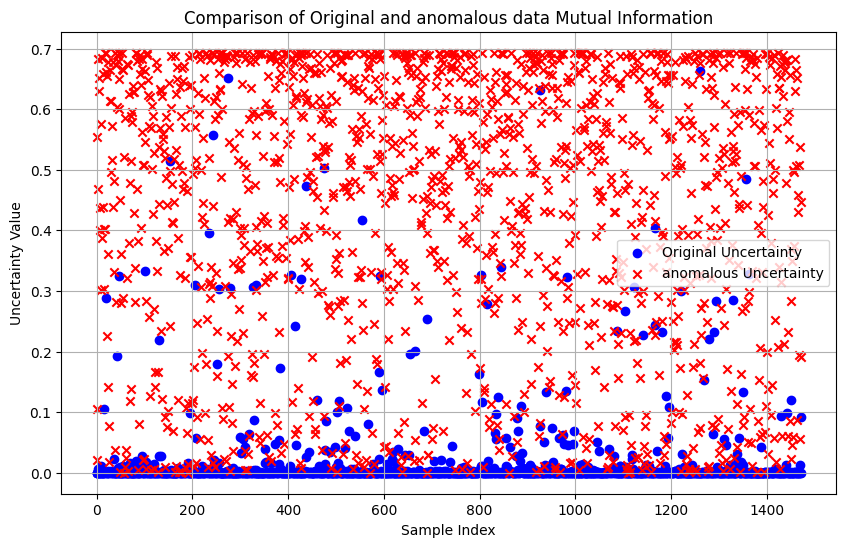

In [29]:
# Scatter plot without connecting the points

plt.figure(figsize=(10, 6))

plt.scatter(range(len(uncertainties_original_PE)), uncertainties_original_PE, label='Original Uncertainty', marker='o', color='b')

plt.scatter(range(len(uncertainties_generated_PE)), uncertainties_generated_PE, label='anomalous Uncertainty', marker='x', color='r')



# Adding title and labels

plt.title("Comparison of Original and anomalous data Mutual Information")

plt.xlabel("Sample Index")

plt.ylabel("Uncertainty Value")

plt.legend()

plt.savefig("uncertainity_predictive_entropy_AN.png",dpi=300)





# Show the plot

plt.grid(True)

plt.show()


In [30]:
from tqdm import tqdm

modifiable_feature_indices = [4, 5, 6, 7]



# Define the number of samples for uncertainty estimation

num_samples = 10



# Initialize lists to store uncertainties

uncertainties_original_MI = []

uncertainties_generated_MI = []



# Define the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model5.to(device)

model5.eval()



# Iterate over the test set

for inputs, labels in tqdm(test_loader, desc="Processing test set"):

    inputs, labels = inputs.to(device), labels.to(device)



    # Create a binary mask matching the input shape

    batch_size, window_size, num_features = inputs.shape

    mask = torch.zeros_like(inputs, dtype=torch.float32)

    mask[:, :, modifiable_feature_indices] = 1



    # Collect uncertainties for each sample in the batch

    for i in range(batch_size):  # Process one sample at a time

        single_input = inputs[i].unsqueeze(0)  # Shape: (1, window_size, num_features)

        single_mask = mask[i].unsqueeze(0)     # Shape: (1, window_size, num_features)



        # Original sample uncertainty

        outputs_original_samples = []

        for _ in range(num_samples):

            sample_outputs, _ = model5(single_input)
            
            sample_outputs = sample_outputs.cpu().detach().numpy()
            
            class_probs = np.stack([sample_outputs, 1 - sample_outputs], axis=-1)

            outputs_original_samples.append(class_probs)



        # Stack outputs and calculate uncertainty

        outputs_original_samples = np.array(outputs_original_samples).squeeze(1)

        uncertainty_original = mutual_information(outputs_original_samples)

        uncertainties_original_MI.append(uncertainty_original)



# Process drifted data
for inputs, labels in tqdm(anomalous_test_loader, desc="Processing drifted data"):
    
    inputs1, labels1 = inputs.to(device), labels.to(device)
    
    # Collect uncertainties for each sample in the batch

    for i in range(batch_size):  # Process one sample at a time

        single_input1 = inputs1[i].unsqueeze(0)  # Shape: (1, window_size, num_features)

        single_mask = mask[i].unsqueeze(0)     # Shape: (1, window_size, num_features)



        # Original sample uncertainty

        outputs_generated_samples = []

        for _ in range(num_samples):

            sample_outputs, _ = model5(single_input1)
            
            sample_outputs = sample_outputs.cpu().detach().numpy()
            
            class_probs = np.stack([sample_outputs, 1 - sample_outputs], axis=-1)

            outputs_generated_samples.append(class_probs)



        # Stack outputs and calculate uncertainty

        outputs_generated_samples = np.array(outputs_generated_samples).squeeze(1)

        uncertainties_generated = mutual_information(outputs_generated_samples)

        uncertainties_generated_MI.append(uncertainties_generated)



# Calculate mean uncertainties for original and generated data

mean_uncertainty_original = sum(uncertainties_original_MI) / len(uncertainties_original_MI)

mean_uncertainty_generated = sum(uncertainties_generated_MI) / len(uncertainties_generated_MI)



# Print mean uncertainties


# Convert NumPy arrays to scalars before printing
print(f'Mean Predictive Uncertainty on Original Data: {mean_uncertainty_original.item():.4f}')

print(f'Mean Predictive Uncertainty on Generated Data: {mean_uncertainty_generated.item():.4f}')



Processing drifted data: 100%|██████████| 46/46 [13:28<00:00, 17.57s/it]

Mean Predictive Uncertainty on Original Data: 0.0121
Mean Predictive Uncertainty on Generated Data: 0.2797


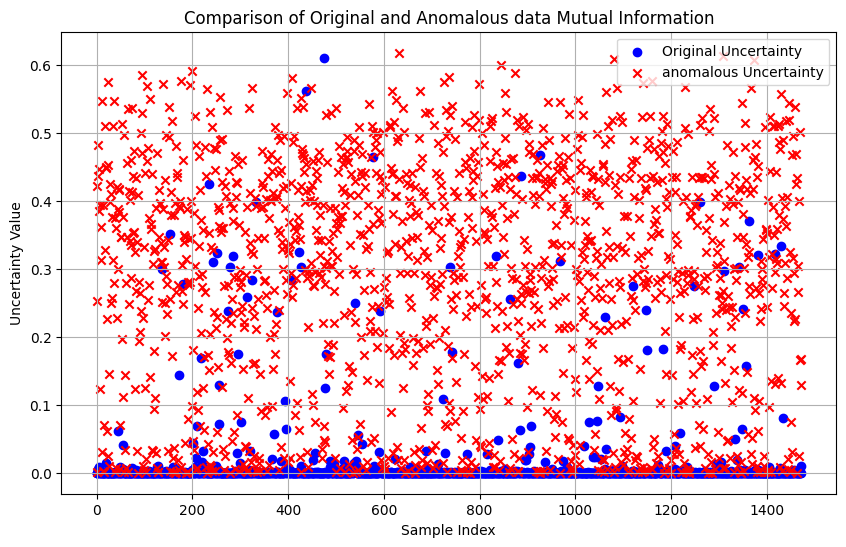

In [31]:
# Scatter plot without connecting the points

plt.figure(figsize=(10, 6))

plt.scatter(range(len(uncertainties_original_MI)), uncertainties_original_MI, label='Original Uncertainty', marker='o', color='b')

plt.scatter(range(len(uncertainties_generated_MI)), uncertainties_generated_MI, label='anomalous Uncertainty', marker='x', color='r')



# Adding title and labels

plt.title("Comparison of Original and Anomalous data Mutual Information")

plt.xlabel("Sample Index")

plt.ylabel("Uncertainty Value")

plt.legend()

plt.savefig("uncertainity_MI_AN.png",dpi=300)





# Show the plot

plt.grid(True)

plt.show()


Shape of jem_original (flattened): (1472,)
Shape of jem_generated (flattened): (1472,)
Shape of all_jem_values (flattened): (2944,)
Length of clusters: 2944
Length of all_jem_values: 2944
Accuracy for Original Data: 0.9871
Accuracy for Generated Data: 0.7595
Overall Accuracy: 0.8733
Overall Precision: 0.9833
Overall Recall: 0.7595
Overall F1-Score: 0.8570


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


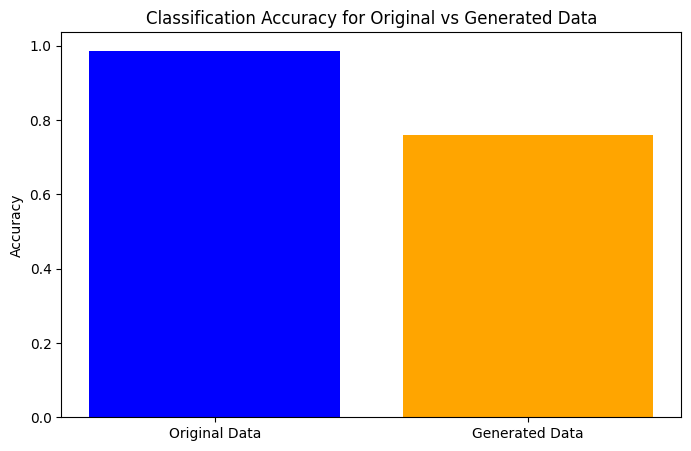

In [32]:
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Set parameters
num_samples = 10
batch_size = 4  # Adjust batch size as needed for incremental updates

# Initialize lists to store uncertainties
uncertainties_original = []
uncertainties_generated = []

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model5.to(device)
model5.eval()
# Define the MiniBatchKMeans with two clusters (for real and adversarial data)
num_clusters = 2
kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size=batch_size, random_state=0)
w1= 1.4
w2= 1
# Combine uncertainties into arrays
uncertainties_original = np.column_stack((uncertainties_original_PE, uncertainties_original_MI))
uncertainties_generated = np.column_stack((uncertainties_generated_PE, uncertainties_generated_MI))

# Calculate JEM for original and generated data
def calculate_jem(uncertainties):
    return w1 * uncertainties[:, 0] + w2* uncertainties[:, 1]

jem_original = calculate_jem(uncertainties_original)
jem_generated = calculate_jem(uncertainties_generated)

# Flatten jem_original and jem_generated
jem_original = jem_original.flatten()
jem_generated = jem_generated.flatten()

# Concatenate to form all_jem_values
all_jem_values = np.concatenate([jem_original, jem_generated])

# Debugging: Print the shapes again
print(f"Shape of jem_original (flattened): {jem_original.shape}")
print(f"Shape of jem_generated (flattened): {jem_generated.shape}")
print(f"Shape of all_jem_values (flattened): {all_jem_values.shape}")

# Update the K-Means model with each batch
kmeans.partial_fit(all_jem_values.reshape(-1, 1))

# Apply clustering
clusters = kmeans.predict(all_jem_values.reshape(-1, 1))

# Check length consistency
print(f"Length of clusters: {len(clusters)}")
print(f"Length of all_jem_values: {len(all_jem_values)}")

if len(clusters) != len(all_jem_values):
    raise ValueError(f"Mismatch: clusters length ({len(clusters)}) != all_jem_values length ({len(all_jem_values)})")

# Assign labels based on proximity to mean uncertainty of original data
mean_original_uncertainty = jem_original.mean()
cluster_means = [all_jem_values[clusters == i].mean() for i in range(num_clusters)]

assigned_labels = np.zeros_like(clusters)
for i, mean in enumerate(cluster_means):
    if abs(mean - mean_original_uncertainty) < abs(cluster_means[1 - i] - mean_original_uncertainty):
        assigned_labels[clusters == i] = 0  # Closer to original data mean
    else:
        assigned_labels[clusters == i] = 1  # Farther from original data mean

# Combine true labels for evaluation
true_labels_original = np.zeros(len(jem_original))  # Original data
true_labels_generated = np.ones(len(jem_generated))  # Generated data
all_true_labels = np.concatenate([true_labels_original, true_labels_generated])

# Calculate metrics
accuracy_original = accuracy_score(true_labels_original, assigned_labels[:len(jem_original)])
accuracy_generated = accuracy_score(true_labels_generated, assigned_labels[len(jem_original):])

# Print accuracies
print(f'Accuracy for Original Data: {accuracy_original:.4f}')
print(f'Accuracy for Generated Data: {accuracy_generated:.4f}')

# Overall metrics
overall_accuracy = accuracy_score(all_true_labels, assigned_labels)
overall_precision = precision_score(all_true_labels, assigned_labels)
overall_recall = recall_score(all_true_labels, assigned_labels)
overall_f1 = f1_score(all_true_labels, assigned_labels)

# Print overall metrics
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'Overall Precision: {overall_precision:.4f}')
print(f'Overall Recall: {overall_recall:.4f}')
print(f'Overall F1-Score: {overall_f1:.4f}')

# Plot the results
plt.figure(figsize=(8, 5))
plt.bar(['Original Data', 'Generated Data'], [accuracy_original, accuracy_generated], color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Classification Accuracy for Original vs Generated Data')
plt.show()


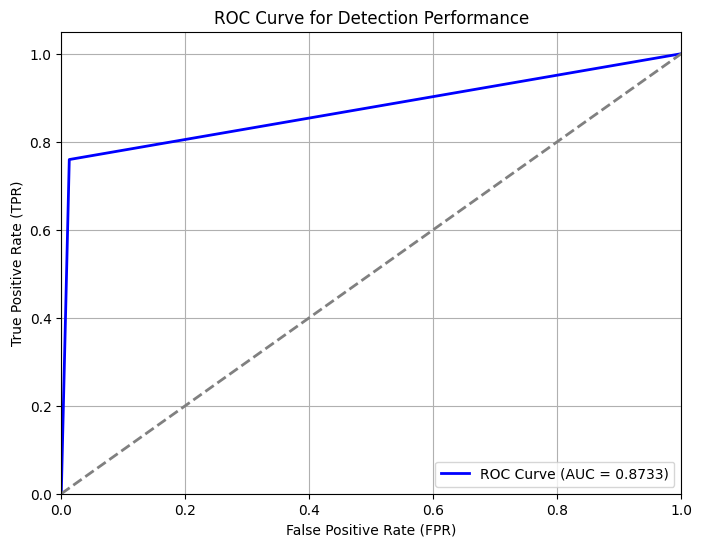

ROC AUC Score: 0.8733


In [33]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(all_true_labels, assigned_labels)
roc_auc = roc_auc_score(all_true_labels, assigned_labels)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Detection Performance')
plt.legend(loc="lower right")
plt.savefig("roc",dpi=300)
plt.grid()
plt.show()

# Print AUC Score
print(f'ROC AUC Score: {roc_auc:.4f}')


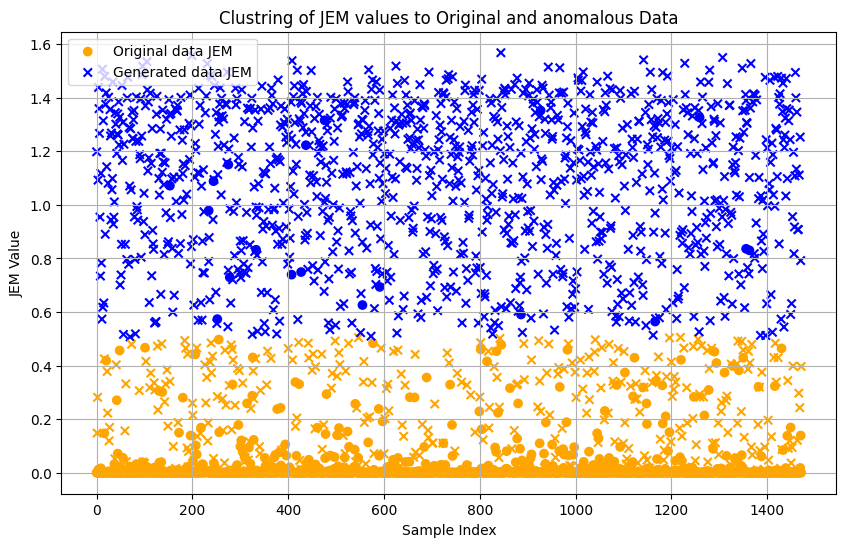

In [34]:
# Scatter plot without connecting the points
plt.figure(figsize=(10, 6))

# Plot original uncertainty values with cluster colors
plt.scatter(range(len(jem_original)), 
            jem_original, 
            label='Original data JEM', 
            marker='o', 
            color=['blue' if cluster == 0 else 'orange' for cluster in clusters[:len(jem_original)]])

# Plot generated uncertainty values with cluster colors
plt.scatter(range(len(jem_generated)), 
            jem_generated, 
            label='Generated data JEM', 
            marker='x', 
            color=['blue' if cluster == 0 else 'orange' for cluster in clusters[len(jem_original):]])

# Adding title and labels
plt.title("Clustring of JEM values to Original and anomalous Data")
plt.xlabel("Sample Index")
plt.ylabel("JEM Value")
plt.legend()
# Save the plot
plt.savefig("/kaggle/working/uncertainty_JEM_AN.png", dpi=300)


# Show the plot
plt.grid(True)
plt.show()

In [35]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(jem_original, jem_generated, alternative='two-sided')
print(f'[📊 Mann-Whitney U] Statistic={stat:.4f}, p-value={p_value:.4e}')


[📊 Mann-Whitney U] Statistic=43835.0000, p-value=0.0000e+00


In [36]:
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1)*np.std(x, ddof=1)**2 + (ny - 1)*np.std(y, ddof=1)**2) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

d = cohen_d(jem_original, jem_generated)
print(f"[📐 Cohen's d] Effect Size: {d:.4f}")


[📐 Cohen's d] Effect Size: -2.6144


In [37]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Clustering metrics
silhouette = silhouette_score(all_jem_values.reshape(-1, 1), clusters)
db_index = davies_bouldin_score(all_jem_values.reshape(-1, 1), clusters)

print(f'[📈 Silhouette Score]: {silhouette:.4f} (higher is better)')
print(f'[📉 Davies-Bouldin Index]: {db_index:.4f} (lower is better)')


[📈 Silhouette Score]: 0.7873 (higher is better)
[📉 Davies-Bouldin Index]: 0.3218 (lower is better)


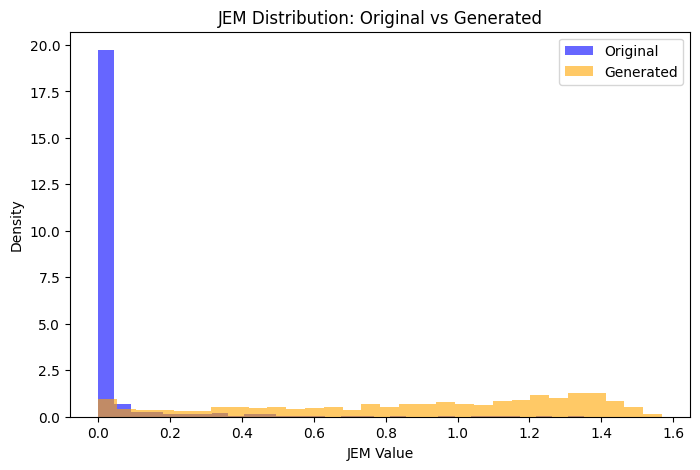

In [38]:
plt.figure(figsize=(8, 5))
plt.hist(jem_original, bins=30, alpha=0.6, label='Original', color='blue', density=True)
plt.hist(jem_generated, bins=30, alpha=0.6, label='Generated', color='orange', density=True)
plt.xlabel('JEM Value')
plt.ylabel('Density')
plt.title('JEM Distribution: Original vs Generated')
plt.legend()
plt.show()


In [39]:
from sklearn.utils import resample

def bootstrap_ci(metric_func, y_true, y_pred, n_iterations=1000, alpha=0.95):
    stats = []
    for _ in range(n_iterations):
        indices = np.random.choice(len(y_true), size=len(y_true), replace=True)
        stat = metric_func(np.array(y_true)[indices], np.array(y_pred)[indices])
        stats.append(stat)
    lower = np.percentile(stats, ((1.0 - alpha) / 2.0) * 100)
    upper = np.percentile(stats, (alpha + (1.0 - alpha) / 2.0) * 100)
    return lower, upper

# Get CIs for metrics
acc_ci = bootstrap_ci(accuracy_score, all_true_labels, assigned_labels)
precision_ci = bootstrap_ci(precision_score, all_true_labels, assigned_labels)
recall_ci = bootstrap_ci(recall_score, all_true_labels, assigned_labels)
f1_ci = bootstrap_ci(f1_score, all_true_labels, assigned_labels)

# Print metrics with CI
print(f"[✅ Accuracy] {overall_accuracy:.3f} [{acc_ci[0]:.3f}, {acc_ci[1]:.3f}]")
print(f"[📌 Precision] {overall_precision:.3f} [{precision_ci[0]:.3f}, {precision_ci[1]:.3f}]")
print(f"[📍 Recall] {overall_recall:.3f} [{recall_ci[0]:.3f}, {recall_ci[1]:.3f}]")
print(f"[🎯 F1 Score] {overall_f1:.3f} [{f1_ci[0]:.3f}, {f1_ci[1]:.3f}]")


[✅ Accuracy] 0.873 [0.861, 0.885]
[📌 Precision] 0.983 [0.977, 0.990]
[📍 Recall] 0.760 [0.738, 0.782]
[🎯 F1 Score] 0.857 [0.842, 0.870]


# Uncertainty Based Anomaly detection for GAN-GRID

In [23]:
from tqdm import tqdm

modifiable_feature_indices = [4, 5, 6, 7]



# Define the number of samples for uncertainty estimation

num_samples = 10



# Initialize lists to store uncertainties

uncertainties_original_PE = []

uncertainties_generated_PE = []



# Define the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model5.to(device)

model5.eval()



# Assuming generator is defined and moved to the correct device

generator.to(device)



# Iterate over the test set

for inputs, labels in tqdm(test_loader, desc="Processing test set"):

    inputs, labels = inputs.to(device), labels.to(device)



    # Create a binary mask matching the input shape

    batch_size, window_size, num_features = inputs.shape

    mask = torch.zeros_like(inputs, dtype=torch.float32)

    mask[:, :, modifiable_feature_indices] = 1



    # Collect uncertainties for each sample in the batch

    for i in range(batch_size):  # Process one sample at a time

        single_input = inputs[i].unsqueeze(0)  # Shape: (1, window_size, num_features)

        single_mask = mask[i].unsqueeze(0)     # Shape: (1, window_size, num_features)



        # Original sample uncertainty

        outputs_original_samples = []

        for _ in range(num_samples):

            sample_outputs, _ = model5(single_input)
            
            sample_outputs = sample_outputs.cpu().detach().numpy()
            
            class_probs = np.stack([sample_outputs, 1 - sample_outputs], axis=-1)

            outputs_original_samples.append(class_probs)



        # Stack outputs and calculate uncertainty

        outputs_original_samples = np.array(outputs_original_samples).squeeze(1)

        uncertainty_original = predictive_entropy(outputs_original_samples)

        uncertainties_original_PE.append(uncertainty_original)



        # Generated data

        random_noise = torch.randn_like(single_input)  # Shape: (1, window_size, num_features)

        generated_data = generator(random_noise)

        modified_generated_data = generated_data * single_mask + single_input * (1 - single_mask)



        # Generated sample uncertainty

        outputs_generated_samples = []

        for _ in range(num_samples):

            sample_outputs, _ = model5(modified_generated_data)
            
            sample_outputs = sample_outputs.cpu().detach().numpy()
            
            class_probs = np.stack([sample_outputs, 1 - sample_outputs], axis=-1)

            outputs_generated_samples.append(class_probs)



        # Stack outputs and calculate uncertainty

        outputs_generated_samples = np.array(outputs_generated_samples).squeeze(1)

        uncertainty_generated = predictive_entropy(outputs_generated_samples)

        uncertainties_generated_PE.append(uncertainty_generated)



# Calculate mean uncertainties for original and generated data

mean_uncertainty_original = sum(uncertainties_original_PE) / len(uncertainties_original_PE)

mean_uncertainty_generated = sum(uncertainties_generated_PE) / len(uncertainties_generated_PE)



# Print mean uncertainties


# Convert NumPy arrays to scalars before printing
print(f'Mean Predictive Uncertainty on Original Data: {mean_uncertainty_original.item():.4f}')

print(f'Mean Predictive Uncertainty on Generated Data: {mean_uncertainty_generated.item():.4f}')



Processing test set: 100%|██████████| 46/46 [28:49<00:00, 37.59s/it]

Mean Predictive Uncertainty on Original Data: 0.0159
Mean Predictive Uncertainty on Generated Data: 0.6478


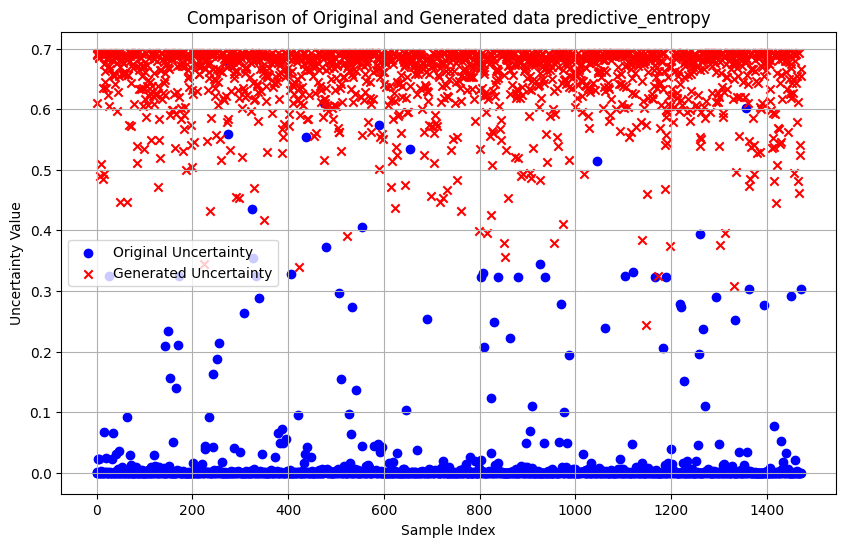

In [24]:
# Scatter plot without connecting the points

plt.figure(figsize=(10, 6))

plt.scatter(range(len(uncertainties_original_PE)), uncertainties_original_PE, label='Original Uncertainty', marker='o', color='b')

plt.scatter(range(len(uncertainties_generated_PE)), uncertainties_generated_PE, label='Generated Uncertainty', marker='x', color='r')



# Adding title and labels

plt.title("Comparison of Original and Generated data predictive_entropy")

plt.xlabel("Sample Index")

plt.ylabel("Uncertainty Value")

plt.legend()

plt.savefig("uncertainity_predictive_entropy.png",dpi=300)





# Show the plot

plt.grid(True)

plt.show()


In [25]:
from tqdm import tqdm

modifiable_feature_indices = [4, 5, 6, 7]



# Define the number of samples for uncertainty estimation

num_samples = 10



# Initialize lists to store uncertainties

uncertainties_original_MI = []

uncertainties_generated_MI = []



# Define the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model5.to(device)

model5.eval()



# Assuming generator is defined and moved to the correct device

generator.to(device)



# Iterate over the test set

for inputs, labels in tqdm(test_loader, desc="Processing test set"):

    inputs, labels = inputs.to(device), labels.to(device)



    # Create a binary mask matching the input shape

    batch_size, window_size, num_features = inputs.shape

    mask = torch.zeros_like(inputs, dtype=torch.float32)

    mask[:, :, modifiable_feature_indices] = 1



    # Collect uncertainties for each sample in the batch

    for i in range(batch_size):  # Process one sample at a time

        single_input = inputs[i].unsqueeze(0)  # Shape: (1, window_size, num_features)

        single_mask = mask[i].unsqueeze(0)     # Shape: (1, window_size, num_features)



        # Original sample uncertainty

        outputs_original_samples = []

        for _ in range(num_samples):

            sample_outputs, _ = model5(single_input)
            
            sample_outputs = sample_outputs.cpu().detach().numpy()
            
            class_probs = np.stack([sample_outputs, 1 - sample_outputs], axis=-1)
            
            outputs_original_samples.append(class_probs)



        # Stack outputs and calculate uncertainty

        outputs_original_samples = np.array(outputs_original_samples).squeeze(1)

        uncertainty_original = mutual_information(outputs_original_samples)

        uncertainties_original_MI.append(uncertainty_original)



        # Generated data

        random_noise = torch.randn_like(single_input)  # Shape: (1, window_size, num_features)

        generated_data = generator(random_noise)

        modified_generated_data = generated_data * single_mask + single_input * (1 - single_mask)



        # Generated sample uncertainty

        outputs_generated_samples = []

        for _ in range(num_samples):

            sample_outputs, _ = model5(modified_generated_data)
            
            sample_outputs = sample_outputs.cpu().detach().numpy()
            
            class_probs = np.stack([sample_outputs, 1 - sample_outputs], axis=-1)
            
            outputs_generated_samples.append(class_probs)



        # Stack outputs and calculate uncertainty

        outputs_generated_samples = np.array(outputs_generated_samples).squeeze(1)

        uncertainty_generated = mutual_information(outputs_generated_samples)

        uncertainties_generated_MI.append(uncertainty_generated)



# Calculate mean uncertainties for original and generated data

mean_uncertainty_original_MI = sum(uncertainties_original_MI) / len(uncertainties_original_MI)

mean_uncertainty_generate_MI = sum(uncertainties_generated_MI) / len(uncertainties_generated_MI)



# Print mean uncertainties

print(f'Mean Predictive Uncertainty on Original Data: {mean_uncertainty_original_MI.item():.4f}')

print(f'Mean Predictive Uncertainty on Generated Data: {mean_uncertainty_generate_MI.item():.4f}')


Processing test set: 100%|██████████| 46/46 [28:23<00:00, 37.03s/it]

Mean Predictive Uncertainty on Original Data: 0.0108
Mean Predictive Uncertainty on Generated Data: 0.4101


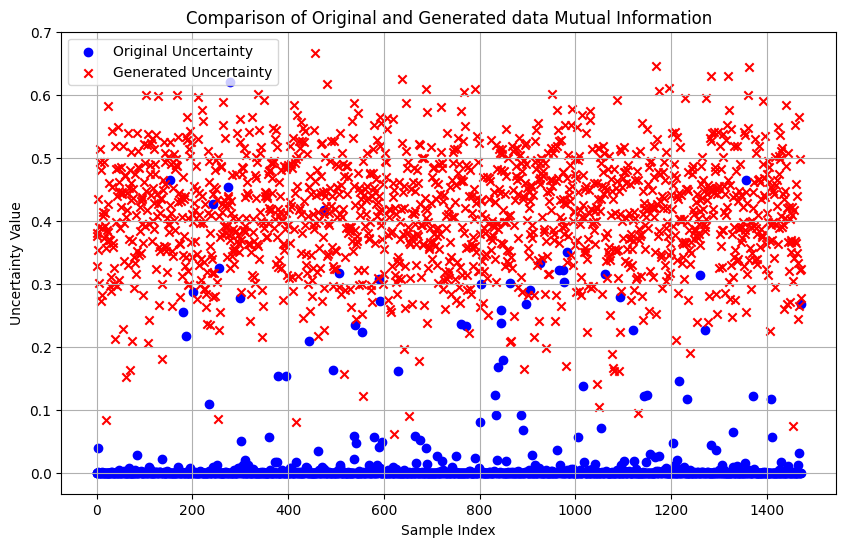

In [26]:
# Scatter plot without connecting the points

plt.figure(figsize=(10, 6))

plt.scatter(range(len(uncertainties_original_MI)), uncertainties_original_MI, label='Original Uncertainty', marker='o', color='b')

plt.scatter(range(len(uncertainties_generated_MI)), uncertainties_generated_MI, label='Generated Uncertainty', marker='x', color='r')



# Adding title and labels

plt.title("Comparison of Original and Generated data Mutual Information")

plt.xlabel("Sample Index")

plt.ylabel("Uncertainty Value")

plt.legend()

plt.savefig("uncertainity_MI.png",dpi=300)





# Show the plot

plt.grid(True)

plt.show()


Shape of jem_original (flattened): (1472,)
Shape of jem_generated (flattened): (1472,)
Shape of all_jem_values (flattened): (2944,)
Length of clusters: 2944
Length of all_jem_values: 2944
Accuracy for Original Data: 0.9898
Accuracy for Generated Data: 1.0000
Overall Accuracy: 0.9949
Overall Precision: 0.9899
Overall Recall: 1.0000
Overall F1-Score: 0.9949


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


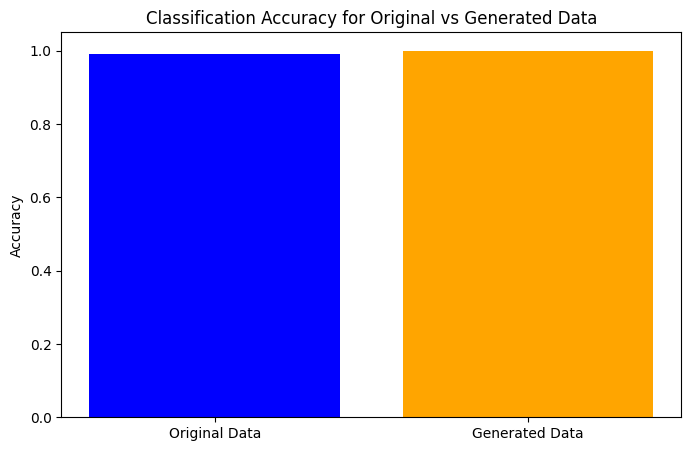

In [27]:
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Set parameters
num_samples = 10
batch_size = 4  # Adjust batch size as needed for incremental updates

# Initialize lists to store uncertainties
uncertainties_original = []
uncertainties_generated = []

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model5.to(device)
model5.eval()
generator.to(device)

# Define the MiniBatchKMeans with two clusters (for real and adversarial data)
num_clusters = 2
kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size=batch_size, random_state=0)
w1= 1.4
w2= 1
# Combine uncertainties into arrays
uncertainties_original = np.column_stack((uncertainties_original_PE, uncertainties_original_MI))
uncertainties_generated = np.column_stack((uncertainties_generated_PE, uncertainties_generated_MI))

# Calculate JEM for original and generated data
def calculate_jem(uncertainties):
    return w1 * uncertainties[:, 0] + w2* uncertainties[:, 1]

jem_original = calculate_jem(uncertainties_original)
jem_generated = calculate_jem(uncertainties_generated)

# Flatten jem_original and jem_generated
jem_original = jem_original.flatten()
jem_generated = jem_generated.flatten()

# Concatenate to form all_jem_values
all_jem_values = np.concatenate([jem_original, jem_generated])

# Debugging: Print the shapes again
print(f"Shape of jem_original (flattened): {jem_original.shape}")
print(f"Shape of jem_generated (flattened): {jem_generated.shape}")
print(f"Shape of all_jem_values (flattened): {all_jem_values.shape}")

# Update the K-Means model with each batch
kmeans.partial_fit(all_jem_values.reshape(-1, 1))

# Apply clustering
clusters = kmeans.predict(all_jem_values.reshape(-1, 1))

# Check length consistency
print(f"Length of clusters: {len(clusters)}")
print(f"Length of all_jem_values: {len(all_jem_values)}")

if len(clusters) != len(all_jem_values):
    raise ValueError(f"Mismatch: clusters length ({len(clusters)}) != all_jem_values length ({len(all_jem_values)})")

# Assign labels based on proximity to mean uncertainty of original data
mean_original_uncertainty = jem_original.mean()
cluster_means = [all_jem_values[clusters == i].mean() for i in range(num_clusters)]

assigned_labels = np.zeros_like(clusters)
for i, mean in enumerate(cluster_means):
    if abs(mean - mean_original_uncertainty) < abs(cluster_means[1 - i] - mean_original_uncertainty):
        assigned_labels[clusters == i] = 0  # Closer to original data mean
    else:
        assigned_labels[clusters == i] = 1  # Farther from original data mean

# Combine true labels for evaluation
true_labels_original = np.zeros(len(jem_original))  # Original data
true_labels_generated = np.ones(len(jem_generated))  # Generated data
all_true_labels = np.concatenate([true_labels_original, true_labels_generated])

# Calculate metrics
accuracy_original = accuracy_score(true_labels_original, assigned_labels[:len(jem_original)])
accuracy_generated = accuracy_score(true_labels_generated, assigned_labels[len(jem_original):])

# Print accuracies
print(f'Accuracy for Original Data: {accuracy_original:.4f}')
print(f'Accuracy for Generated Data: {accuracy_generated:.4f}')

# Overall metrics
overall_accuracy = accuracy_score(all_true_labels, assigned_labels)
overall_precision = precision_score(all_true_labels, assigned_labels)
overall_recall = recall_score(all_true_labels, assigned_labels)
overall_f1 = f1_score(all_true_labels, assigned_labels)

# Print overall metrics
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'Overall Precision: {overall_precision:.4f}')
print(f'Overall Recall: {overall_recall:.4f}')
print(f'Overall F1-Score: {overall_f1:.4f}')

# Plot the results
plt.figure(figsize=(8, 5))
plt.bar(['Original Data', 'Generated Data'], [accuracy_original, accuracy_generated], color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Classification Accuracy for Original vs Generated Data')
plt.show()


In [28]:
mean_original_uncertainty

0.03309428

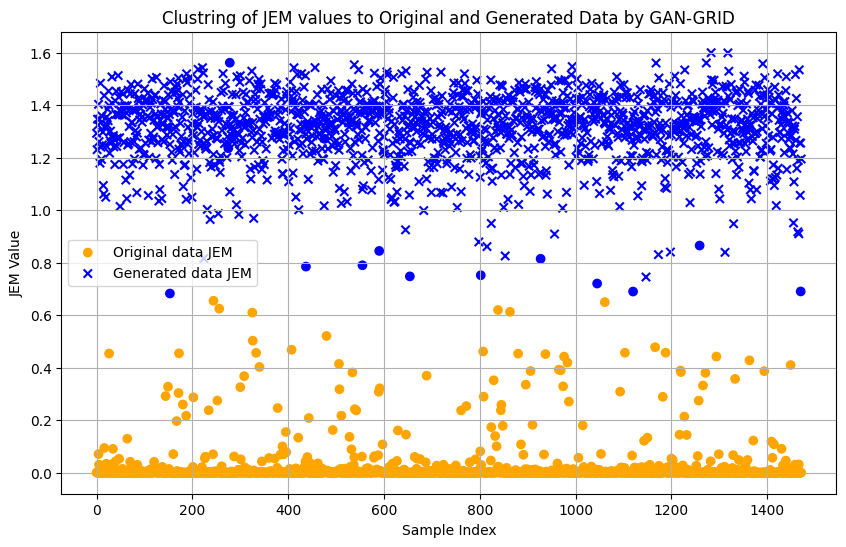

In [29]:
# Scatter plot without connecting the points
plt.figure(figsize=(10, 6))

# Plot original uncertainty values with cluster colors
plt.scatter(range(len(jem_original)), 
            jem_original, 
            label='Original data JEM', 
            marker='o', 
            color=['blue' if cluster == 0 else 'orange' for cluster in clusters[:len(jem_original)]])

# Plot generated uncertainty values with cluster colors
plt.scatter(range(len(jem_generated)), 
            jem_generated, 
            label='Generated data JEM', 
            marker='x', 
            color=['blue' if cluster == 0 else 'orange' for cluster in clusters[len(jem_original):]])

# Adding title and labels
plt.title("Clustring of JEM values to Original and Generated Data by GAN-GRID")
plt.xlabel("Sample Index")
plt.ylabel("JEM Value")
plt.legend()
# Save the plot
plt.savefig("uncertainty_JEM.png", dpi=300)


# Show the plot
plt.grid(True)
plt.show()

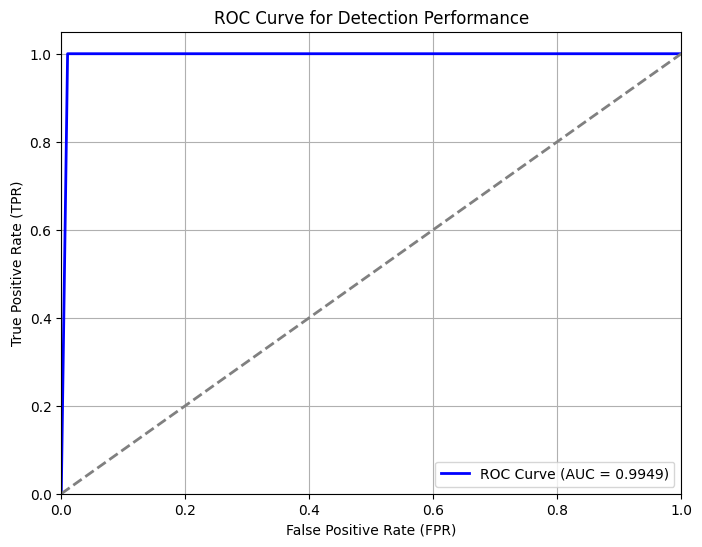

ROC AUC Score: 0.9949


In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(all_true_labels, assigned_labels)
roc_auc = roc_auc_score(all_true_labels, assigned_labels)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Detection Performance')
plt.legend(loc="lower right")
plt.savefig("roc1",dpi=300)
plt.grid()
plt.show()

# Print AUC Score
print(f'ROC AUC Score: {roc_auc:.4f}')


In [31]:
print(cluster_means[0])

print(cluster_means[1])

1.3130308
0.023988979


In [32]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(jem_original, jem_generated, alternative='two-sided')
print(f'[📊 Mann-Whitney U] Statistic={stat:.4f}, p-value={p_value:.4e}')


[📊 Mann-Whitney U] Statistic=2844.0000, p-value=0.0000e+00


In [33]:
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1)*np.std(x, ddof=1)**2 + (ny - 1)*np.std(y, ddof=1)**2) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

d = cohen_d(jem_original, jem_generated)
print(f"[📐 Cohen's d] Effect Size: {d:.4f}")


[📐 Cohen's d] Effect Size: -10.4519


In [34]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Clustering metrics
silhouette = silhouette_score(all_jem_values.reshape(-1, 1), clusters)
db_index = davies_bouldin_score(all_jem_values.reshape(-1, 1), clusters)

print(f'[📈 Silhouette Score]: {silhouette:.4f} (higher is better)')
print(f'[📉 Davies-Bouldin Index]: {db_index:.4f} (lower is better)')


[📈 Silhouette Score]: 0.9233 (higher is better)
[📉 Davies-Bouldin Index]: 0.1049 (lower is better)


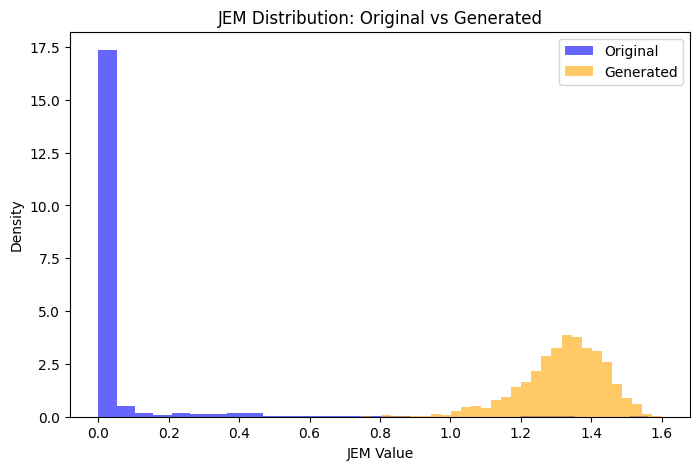

In [35]:
plt.figure(figsize=(8, 5))
plt.hist(jem_original, bins=30, alpha=0.6, label='Original', color='blue', density=True)
plt.hist(jem_generated, bins=30, alpha=0.6, label='Generated', color='orange', density=True)
plt.xlabel('JEM Value')
plt.ylabel('Density')
plt.title('JEM Distribution: Original vs Generated')
plt.legend()
plt.show()


In [36]:
from sklearn.utils import resample

def bootstrap_ci(metric_func, y_true, y_pred, n_iterations=1000, alpha=0.95):
    stats = []
    for _ in range(n_iterations):
        indices = np.random.choice(len(y_true), size=len(y_true), replace=True)
        stat = metric_func(np.array(y_true)[indices], np.array(y_pred)[indices])
        stats.append(stat)
    lower = np.percentile(stats, ((1.0 - alpha) / 2.0) * 100)
    upper = np.percentile(stats, (alpha + (1.0 - alpha) / 2.0) * 100)
    return lower, upper

# Get CIs for metrics
acc_ci = bootstrap_ci(accuracy_score, all_true_labels, assigned_labels)
precision_ci = bootstrap_ci(precision_score, all_true_labels, assigned_labels)
recall_ci = bootstrap_ci(recall_score, all_true_labels, assigned_labels)
f1_ci = bootstrap_ci(f1_score, all_true_labels, assigned_labels)

# Print metrics with CI
print(f"[✅ Accuracy] {overall_accuracy:.3f} [{acc_ci[0]:.3f}, {acc_ci[1]:.3f}]")
print(f"[📌 Precision] {overall_precision:.3f} [{precision_ci[0]:.3f}, {precision_ci[1]:.3f}]")
print(f"[📍 Recall] {overall_recall:.3f} [{recall_ci[0]:.3f}, {recall_ci[1]:.3f}]")
print(f"[🎯 F1 Score] {overall_f1:.3f} [{f1_ci[0]:.3f}, {f1_ci[1]:.3f}]")


[✅ Accuracy] 0.995 [0.992, 0.997]
[📌 Precision] 0.990 [0.985, 0.995]
[📍 Recall] 1.000 [1.000, 1.000]
[🎯 F1 Score] 0.995 [0.992, 0.997]
